In [23]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from matplotlib import animation
import optax
from IPython.display import HTML
import time

In [24]:
def to_so2(angle):
    """Convert an angle to a 2D rotation matrix."""
    return jnp.array([[jnp.cos(angle), -jnp.sin(angle)],
                      [jnp.sin(angle), jnp.cos(angle)]])

def fk(angles, link_lengths, base_pos=jnp.zeros(2)):
    """Compute forward kinematics of a planar robot arm."""
    assert angles.shape == link_lengths.shape, (angles.shape, link_lengths.shape)
    positions = jnp.zeros((len(angles) + 1, 2))
    positions = positions.at[0].set(base_pos)
    for i, (a, l) in enumerate(zip(jnp.cumsum(angles), link_lengths)):
        positions = positions.at[i + 1].set(positions[i] + to_so2(a) @ jnp.array([l, 0]))
    return positions

def draw_arm(ax, angles, link_lengths, base_pos=jnp.zeros(2)):
    """Draw a planar robot arm as a series of line segments."""
    assert angles.shape == link_lengths.shape
    positions = fk(angles, link_lengths, base_pos)
    ax.plot(positions[:, 0], positions[:, 1], 'k.-')

In [25]:
# Constraints from the paper https://crl.ethz.ch/papers/iros23_dtamp.pdf

def position_constraint(w, ee_pos, obj_pos):
    """Compute the position constraint.

    Args:
        w: (n, m)
        ee_pos: (n, 2)
        obj_pos: (m, 2)
    
    Returns:
        (n, m, 2)
    """
    return w[:, :, None] * (ee_pos[:, None, :] - obj_pos[None, :, :])

def velocity_constraint(w, ee_vel, obj_vel):
    """Compute the velocity constraint.

    Args:
        w: (n, m)
        ee_vel: (n, 2)
        obj_vel: (m, 2)
    
    Returns:
        (m, 2)
    """
    return obj_vel - w.T @ ee_vel

In [26]:
# Problem configuration
T = 30  # Number of knots
N = 4  # Number of arms
M = 1  # Number of objects
J = 2  # Number of joints per arm

# Hyperparameters
joint_velocity_regularization_weight = 1e-2
object_velocity_regularization_weight = 1e-1

# Environment configuration
base_positions = jnp.array([[i, 0.25 * i] for i in range(N)])
link_lengths = jnp.ones((N, J)) * 0.7
start_position = jnp.array([[-1.0, 1.0]])
target_position = jnp.array([[4.0, 1.0]])
assert base_positions.shape == (N, 2)
assert link_lengths.shape == (N, J)
assert start_position.shape == (M, 2)
assert target_position.shape == (M, 2)

# Decision variables (init object positions to a straight line between start and target)
initial_association_weights = jnp.ones((T, N, M)) / (N * M)
initial_joint_positions = jnp.ones((T, N, J))
initial_object_positions = jnp.array(
    [
        (1 - alpha) * start_position + alpha * target_position
        for alpha in jnp.linspace(0, 1, T, endpoint=True)
    ]
)
assert initial_association_weights.shape == (T, N, M)
assert initial_joint_positions.shape == (T, N, J)
assert initial_object_positions.shape == (T, M, 2)
params = (
    initial_association_weights,
    initial_joint_positions,
    initial_object_positions,
)

Solved in 0.18 seconds


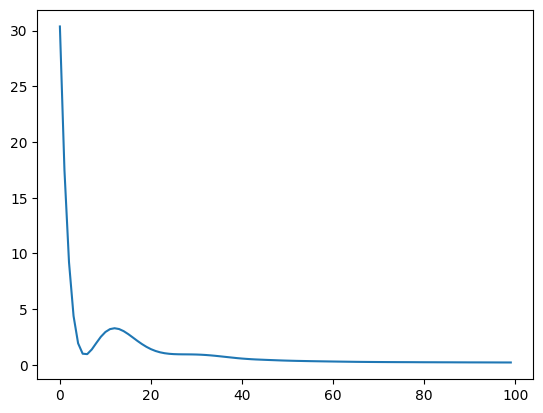

In [27]:
# Vectorized methods for computing constraints on all knots
fk_for_all_arms = jax.vmap(lambda *args: fk(*args)[-1], in_axes=(0, 0, 0))
fk_for_all_knots = jax.vmap(fk_for_all_arms, in_axes=(0, None, None))
position_constraint_for_all_knots = jax.vmap(position_constraint)
velocity_constraint_for_all_knots = jax.vmap(velocity_constraint)

def compute_loss(params):
    association_weights, joint_positions, object_positions = params

    # Forward kinematics
    ee_positions = fk_for_all_knots(joint_positions, link_lengths, base_positions)
    assert ee_positions.shape == (T, N, 2)

    # Compute velocities
    joint_velocity = jnp.diff(joint_positions, axis=0)
    ee_velocity = jnp.diff(ee_positions, axis=0)
    object_velocity = jnp.diff(object_positions, axis=0)

    # Compute TAMP position constraint violation
    position_error = position_constraint_for_all_knots(
        association_weights, ee_positions, object_positions
    )
    assert position_error.shape == (T, N, M, 2)

    # Compute TAMP velocity constraint violation
    velocity_error = velocity_constraint_for_all_knots(
        0.5 * (association_weights[1:] + association_weights[:-1]), ee_velocity, object_velocity
    )
    assert velocity_error.shape == (T - 1, M, 2)

    # Compute initial error
    initial_error = object_positions[0] - start_position
    assert initial_error.shape == (M, 2)

    # Compute target error at the last knot
    target_error = object_positions[-1] - target_position
    assert target_error.shape == (M, 2)

    return (
        jnp.sum(position_error**2)
        + jnp.sum(velocity_error**2)
        + jnp.sum(initial_error**2)
        + jnp.sum(target_error**2)
        + jnp.sum(joint_velocity**2) * joint_velocity_regularization_weight
        + jnp.sum(object_velocity**2) * object_velocity_regularization_weight
    )

loss_and_grad_fn = jax.jit(jax.value_and_grad(compute_loss))
loss_and_grad_fn(params) # Compile

optimizer = optax.adam(5e-2)
opt_state = optimizer.init(params)
losses = []

t = time.time()
for i in range(100):
    loss, grads = loss_and_grad_fn(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    losses.append(loss)

print(f"Solved in {time.time() - t:.2f} seconds")
plt.plot(losses)


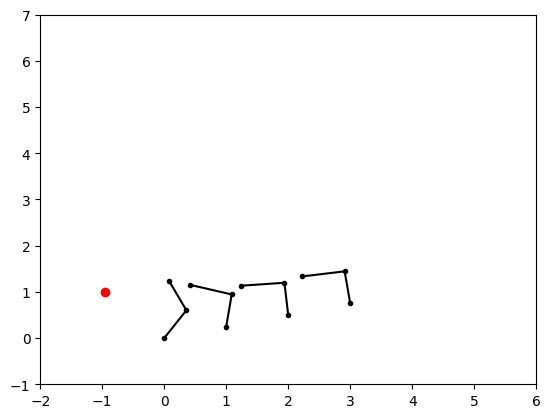

In [28]:
# Animate the results
ax = plt.gca()

def drawframe(knot_idx):
    plt.cla()
    ax.set_xlim(-2, 6)
    ax.set_ylim(-1, 7)
    for arm_idx in range(N):
        draw_arm(ax, params[1][knot_idx, arm_idx], link_lengths[arm_idx], base_positions[arm_idx])

    for obj_idx in range(M):
        ax.plot(*params[2][knot_idx, obj_idx], 'ro')

anim = animation.FuncAnimation(plt.gcf(), drawframe, frames=T, interval=100)
HTML(anim.to_html5_video())